In [ ]:
import os
import math
import string
import zipfile

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.backend as K
from keras.backend import get_value, ctc_decode
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.optimizers import Nadam

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Prepare dataset

In [ ]:
zf = zipfile.ZipFile('/content/drive/MyDrive/Task1/train.zip')
df_train = pd.read_csv(zf.open('train.csv'))

In [ ]:
df_train = df_train.drop(columns='label')
df_train.head()

,text,name
0,постоянный,3957e9bc20e3449ba3cebb5c20c5d34a.png
1,"другой флагманский мотор от Mercedes — 5,5-ли...",9938896eaed945a5bffe8b7b10e31d2e.jpeg
2,"ию поправок в регламент, касающихся из",de6f4e67b9f84f1aa51a87f689382b99.jpeg
3,менения.,49112e7901214d2aa831568210876051.jpeg
4,рганы без повестки отказалась. Учителя и ро,1e82d1d13eb344ef886caafb014a34d0.jpeg


In [ ]:
# Data preprocessing

def preprocess(img):
  for func in [resize_n_rotate, add_adaptiveThreshold]:
    img = func(img)
  return img


def resize_n_rotate(img, shape_to=(64, 512)):
  if img.shape[0] > shape_to[0] or img.shape[1] > shape_to[1]:
    shrink_multiplayer = min(math.floor(shape_to[0] / img.shape[0] * 100) / 100,
                             math.floor(shape_to[1] / img.shape[1] * 100) / 100)
    img = cv2.resize(img, None,
                     fx=shrink_multiplayer,
                     fy=shrink_multiplayer,
                     interpolation=cv2.INTER_AREA)

  img = cv2.copyMakeBorder(img, math.ceil(shape_to[0]/2) - math.ceil(img.shape[0]/2),
                           math.floor(shape_to[0]/2) - math.floor(img.shape[0]/2),
                           math.ceil(shape_to[1]/2) - math.ceil(img.shape[1]/2),
                           math.floor(shape_to[1]/2) - math.floor(img.shape[1]/2),
                           cv2.BORDER_CONSTANT, value=255)
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)


def add_adaptiveThreshold(img):
  return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10).astype('bool')


# Label encoding

def encode_text(texts):
  def _label_to_num(label, alphabet):
    label_num = []
    for ch in label:
      label_num.append(alphabet.find(ch))
    return np.array(label_num)

  alphabet = ''.join(sorted(pd.Series(texts).apply(list).apply(pd.Series).stack().unique()))

  nums = np.ones([len(texts), max([len(text) for text in texts])], dtype='int64') * len(alphabet)
  for i, text in enumerate(texts):
    nums[i][:len(text)] = _label_to_num(text, alphabet)

  return nums, alphabet

In [ ]:
img_list = df_train['name'].tolist()

In [ ]:
N_TRAIN = 10000

In [ ]:
# Load and preprocess data
X_train, Y_train = [], []
zf_imgs = zipfile.ZipFile('/content/drive/MyDrive/Task1/imgs.zip')
for n in tqdm(df_train["name"].values[:N_TRAIN]):
    data = zf_imgs.read("imgs/"+n)
    img = cv2.imdecode(np.frombuffer(data, np.uint8), 0)
    #img = cv2.resize(img, (256, 64))
    X_train.append(preprocess(img))
    Y_train.append(df_train[ df_train['name'] == n]['text'].tolist()[0])

100%|██████████| 10000/10000 [02:01<00:00, 82.52it/s]


In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train, alphabet = encode_text(Y_train)
alphabet

' !"$%&\'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnoprstuvwxyz«°»АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё–—…€№'

In [ ]:
X_train, val_X, Y_train, val_y  = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, test_X, Y_train, test_y  = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

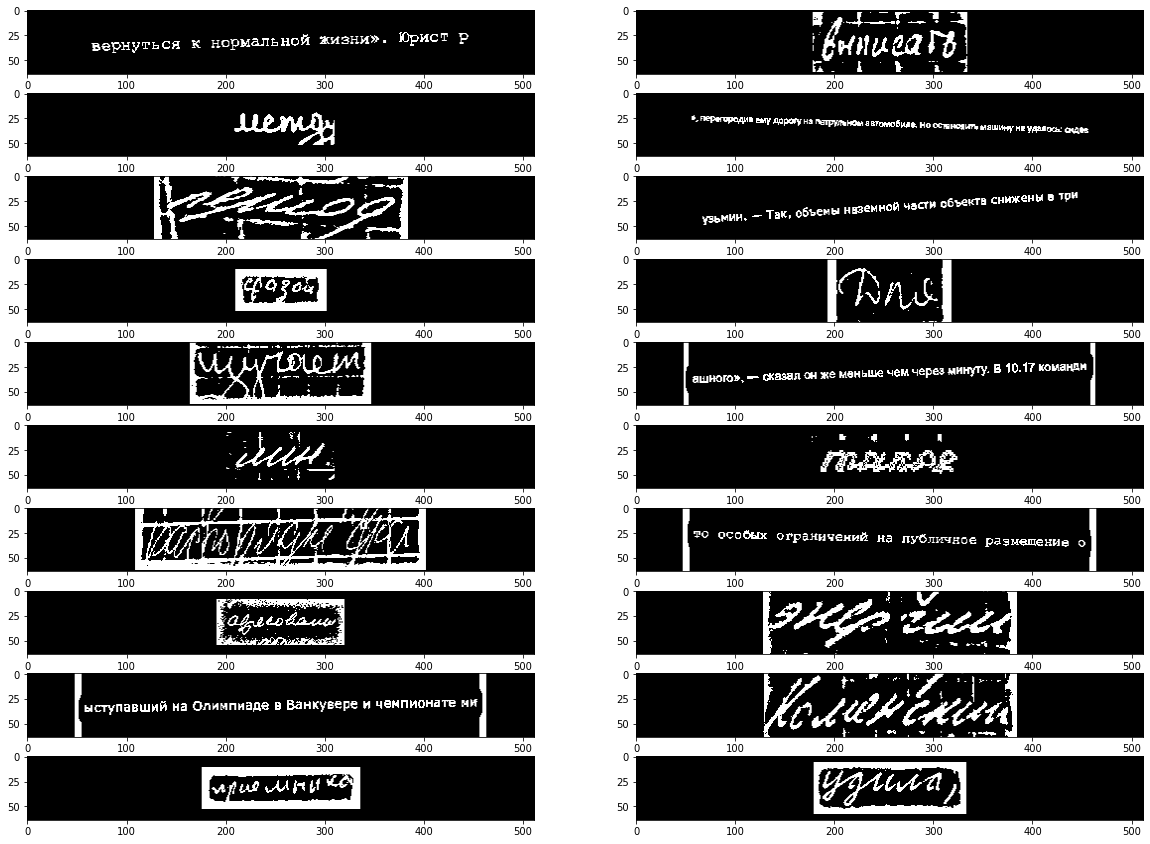

In [ ]:
fig, axes = plt.subplots(figsize=(20, 15), ncols=2, nrows=10)

# Preprocess example

for i in range(10):
  for j in range(2):
    axes[i, j % 2].imshow(cv2.rotate(
        (X_train[i * 2 + j % 2]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
        cmap='gray')

# Model

In [ ]:
class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = K.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * K.cast(input_shape[1], 'float32')

        decode, log = K.ctc_decode(y_pred, input_length, greedy=True)

        decode = K.ctc_label_dense_to_sparse(decode[0], K.cast(input_length, 'int32'))
        y_true_sparse = K.ctc_label_dense_to_sparse(y_true, K.cast(input_length, 'int32'))
        y_true_sparse = tf.sparse.retain(y_true_sparse, tf.not_equal(y_true_sparse.values, tf.math.reduce_max(y_true_sparse.values)))

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(K.cast(len(y_true), 'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)


def CTCLoss(y_true, y_pred):
    """
    Compute the training-time loss value
    """
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
model = Sequential()

model.add(Conv2D(64, (5, 5), padding='same', activation=LeakyReLU(alpha=0.01), input_shape=(512, 64, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (5, 5), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))

model.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))

model.add(Reshape((64, 512)))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))

model.add(Dense(len(alphabet) + 1, activation='softmax')) # +1 for ctc blank

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 64, 64)       1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 32, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 32, 128)      204928    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 16, 128)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 16, 128)      147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 8, 128)      0

In [ ]:
model.compile(optimizer=Nadam(learning_rate=0.001, clipnorm=1.0), loss=CTCLoss, metrics=[CERMetric()])

# Train model

In [ ]:
model_save_path = "drive/MyDrive/Class1.h5"
callback = ModelCheckpoint(model_save_path,monitor="val_loss",save_best_only = True,verbose = 1)

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(val_X, val_y),
                    epochs=75, batch_size=64,
                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True, monitor='loss'),
                              ReduceLROnPlateau(factor=0.5, min_lr=1e-5, patience=4, monitor='loss'),
                               callback],
                    verbose=1)

Epoch 1/75


InvalidArgumentError: ignored

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[1].plot(history.history['CER_metric'], label='CER_metric')
axes[1].plot(history.history['val_CER_metric'], label='val_CER_metric')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Character Error Rate")
axes[1].legend()

plt.show()

In [ ]:
model.save('./crnn.h5')

In [ ]:
# model = load_model('path/to/model', custom_objects={'CTCLoss' : CTCLoss, 'CERMetric': CERMetric})

## Model training results

In [ ]:
# Test results: (loss, cer)

model.evaluate(test_X, test_y)

In [ ]:
# Decode label for single image

def num_to_label(num, alphabet):
    text = ""
    for ch in num:
        if ch == len(alphabet): # ctc blank
          break
        else:
          text += alphabet[ch]
    return text


# Decode labels for softmax matrix

def decode_text(nums):
  values = get_value(
      ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1],
                 greedy=True)[0][0])

  texts = []
  for i in range(nums.shape[0]):
    value = values[i]
    texts.append(num_to_label(value[value >= 0], alphabet))
  return texts

In [ ]:
predicts = model.predict(test_X)
predicts = decode_text(predicts)

In [ ]:
# Prediction results

fig, axes = plt.subplots(figsize=(30, 60), ncols=2, nrows=32)

test_X = test_X.astype('int')

# Title format: GT - Predict
for i in range(64):
  axes[i // 2, i % 2].imshow(cv2.rotate(
      (test_X[i]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
      cmap='gray')
  axes[i // 2, i % 2].set_title(
      f'{num_to_label(test_y[i], alphabet)} - {predicts[i]}')
  axes[i // 2, i % 2].axis("off")